In [ ]:
import tensorflow as tf
import pprint

# Log in to your W&B account
!pip install wandb
import wandb
wandb.login()
# API: 18fe909a998e642a33986bd03c61ee2c6922f72d

# Loading the MNIST dataset in one line
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train_normalized = x_train/255
x_test_normalized = x_test/255
x_train= x_train_normalized.reshape(-1, 28, 28, 1)
x_test = x_test_normalized.reshape(-1, 28, 28, 1)

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=581cf88d1bc27b6142f396d41d5cb65f2a89db8e8ab975d7d5a0d77796e62c94
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


11490434/11490434 [==============================] - 0s 0us/step
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)


In [ ]:
def Net(neurons1=28, neurons2=16, neurons3=64, acivation1='relu',activation2='relu',activation2='relu'):
    return tf.keras.models.Sequential(
    [
    tf.keras.layers.InputLayer(input_shape=(28,28,1)),
    tf.keras.layers.Conv2D(filters=neurons1, kernel_size=5, padding='same', activation=acivation1),
    tf.keras.layers.BatchNormalization,
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(filters=neurons2, kernel_size=5, padding='same', activation=acivation2),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(neurons3, kernel_regularizer = tf.keras.regularizers.l2(0.07), activation = acivation3),
    tf.keras.layers.BatchNormalization,
    tf.keras.layers.GaussianNoise(0.1),
    tf.keras.layers.Dense(10, activation='softmax')
    ]
)

model = Net()
model.summary()

def get_optimizer(lr=1e-3, optimizer="adam"):
    "Select optmizer between adam and sgd with momentum"
    if optimizer.lower() == "adam":
        return tf.keras.optimizers.Adam(learning_rate=lr)
    if optimizer.lower() == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=lr, momentum=0.1)

def train(model, batch_size=64, epochs=10, lr=1e-3, optimizer='adam', log_freq='epoch'):

    # Compile model like you usually do.
    tf.keras.backend.clear_session()

    # Compile modell
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy() #from_logits=True
    sampleID = 100
    loss_fn(y_train[:1], model(x_train[sampleID-1:sampleID]).numpy()).numpy()

    model.compile(loss=loss_fn,
                  optimizer=get_optimizer(lr, optimizer),
                  metrics=['accuracy'])

    # callback setup
    wandb_callbacks = [wandb.keras.WandbCallback(log_freq=log_freq,save_model=(False),) ]

    # Train your model
    model.fit(
        x_train,
        y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_test, y_test),
        callbacks = [wandb_callbacks]
        )

# Configure Sweep
sweep_config = {
    'method': 'random',
    'metric': {
        'goal': 'maximize',
        'name': 'val_accuracy'
    }
}
parameters_dict = {
    'optimizer': {
        'value': 'adam'
        },
    'epochs': {
        'value': 30
        },
    'batch_size' : {
        'values': [16, 32, 64]
        },
    'learning_rate': {
        'values': [0.5e-3, 1e-3, 1.5e-3, 2e-3, 2.5e-3]
    },
     'neurons1': {
        'values': list(range(18,32,2))
    },
    'neurons2': {
        'values': list(range(15,33,3))
    },
    'neurons3': {
        'values': list(range(20,100,5))
    },

    'activation1' : {
        'values' : 'relu', 'tanh', 'sigmoid'
    },
    'activation2' : {
        'values' : 'relu', 'tanh', 'sigmoid'
    },
    'activation3' : {
        'values' : 'relu', 'tanh', 'sigmoid'
    }
}
sweep_config['parameters'] = parameters_dict
pprint.pprint(sweep_config)

def sweep_train(config_defaults=None):
    # Initialize wandb with a sample project name
    with wandb.init(config=config_defaults):  # this gets over-written in the Sweep

        # Specify the other hyperparameters to the configuration, if any
        wandb.config.architecture_name = "V02"
        wandb.config.dataset_name = "MNIST"

        # initialize model
        model = Net(wandb.config.neurons1, wandb.config.neurons2, wandb.config.neurons3)

        train(model,
              wandb.config.batch_size,
              wandb.config.epochs,
              wandb.config.learning_rate,
              wandb.config.optimizer)

sweep_id = wandb.sweep(sweep_config, project="V02_Batch_Activation_Check")
wandb.agent(sweep_id, function=sweep_train, count=100)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 28)        728       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 28)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        11216     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 7, 7, 16)          0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 7, 7, 16)          0         
                                                                 
 flatten (Flatten)           (None, 784)               0

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: 4hfv8s7t
Sweep URL: https://wandb.ai/luchalt/V01_Neuron_Check/sweeps/4hfv8s7t


wandb: Agent Starting Run: jncnfvzd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	neurons1: 34
wandb: 	neurons2: 28
wandb: 	neurons3: 148
wandb: 	optimizer: adam
Exception in thread Thread-17 (_run_job):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/wandb/agents/pyagent.py", line 298, in _run_job
    self._function()
  File "<ipython-input-4-caffbbf70663>", line 91, in sweep_train
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 3120, in __exit__
    self._finish(exit_code=exit_code)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 1932, in _finish
    with telemetry.context(run=self) as tel:
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/lib/telemetry.py", line 42, in __exit__
    self._run._telemetry_callback(self._obj)
  File "/usr/local/lib/python3.10/dist-packages/wandb/sdk/wandb_run.py", line 743, in _telemetry_callback
    self._

In [ ]:
# after the training finishes, we will also save Marvin in Keras style (HDF5), so we do not have to
# train him again
# every time we start our computer. Obviously, by changing the model_name, you can also save different
# configurations of Marvin. The name has to be a string, like this: 'name.h5'
model_name = 'pepsi_p62k_a9915'
model.save(model_name, save_format='h5')

# It is best practice to indicate what configuration changes you did within the name, so you know
# which model you need to load already from its name
# Let's say instead of a learning rate of 0.001 you used 0.1, your naming could then look like:
# 'marvin_lr01.h5'

print('Success! You saved Marvin as: ', model_name)

NameError: name 'pepsi' is not defined

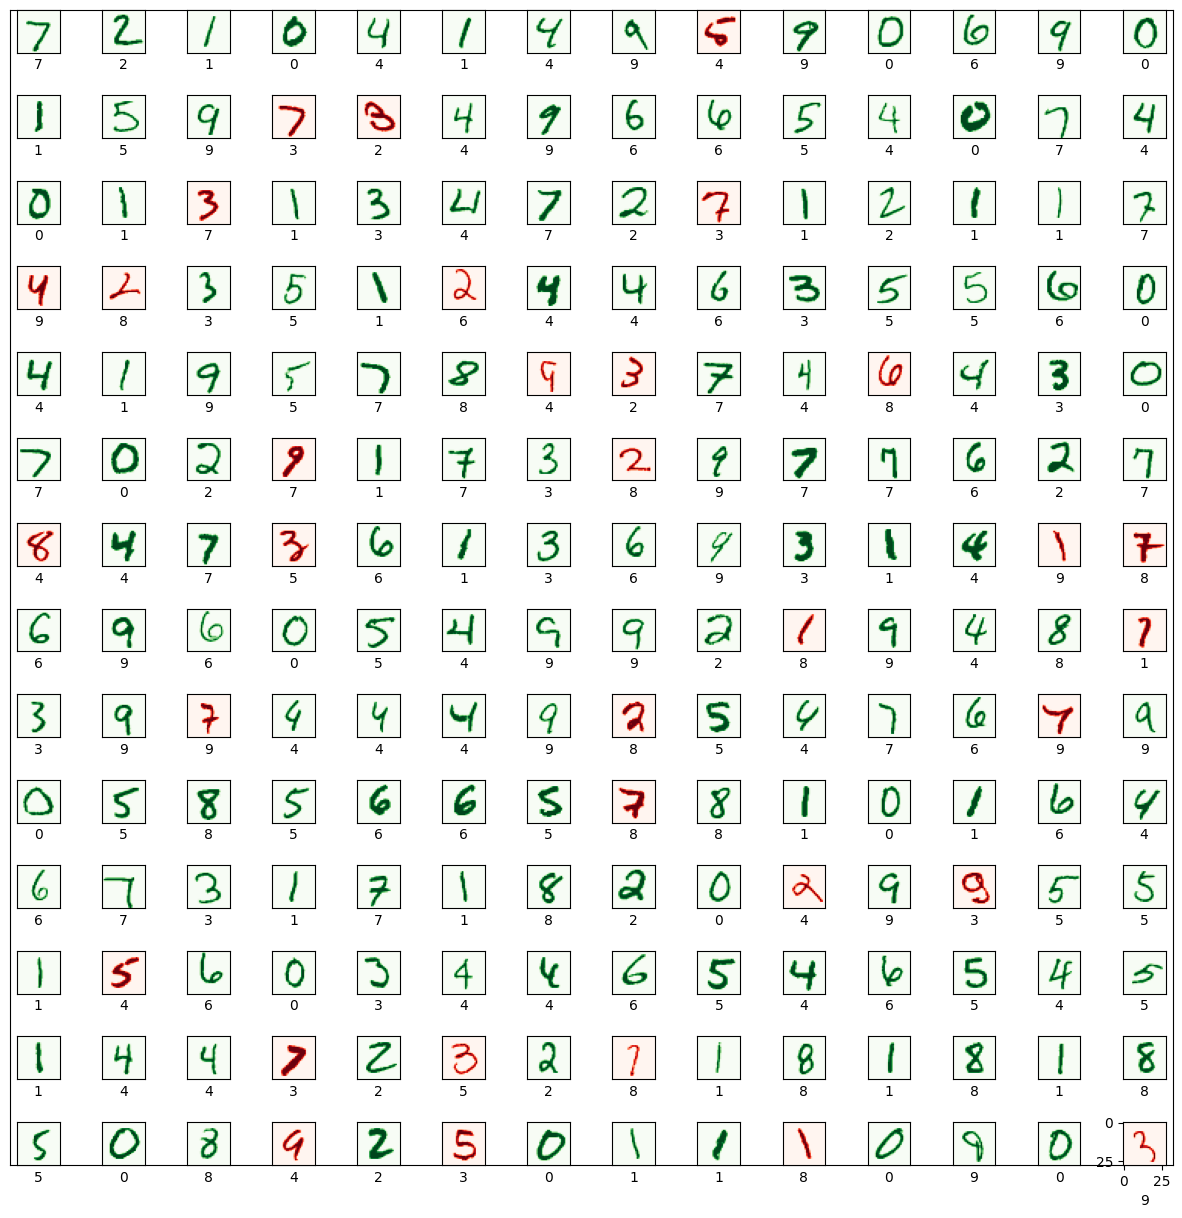

In [ ]:
# load a saved marvin configuration you want to evaluate
model_name = 'pepsi_lr03'
pepsi_reloaded = tf.keras.models.load_model(model_name)

# Let Marvin predict on the test set, so we have some data to evaluate his performance.
predictions = pepsi_reloaded.predict([x_test])
# predictions = pepsi.predict([x_test])

# Remember that the prediction of Marvin is a probability distribution over all ten-digit classes
# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)

# Plot for the intuitive approach

numbers_to_display = 196
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test_normalized[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()

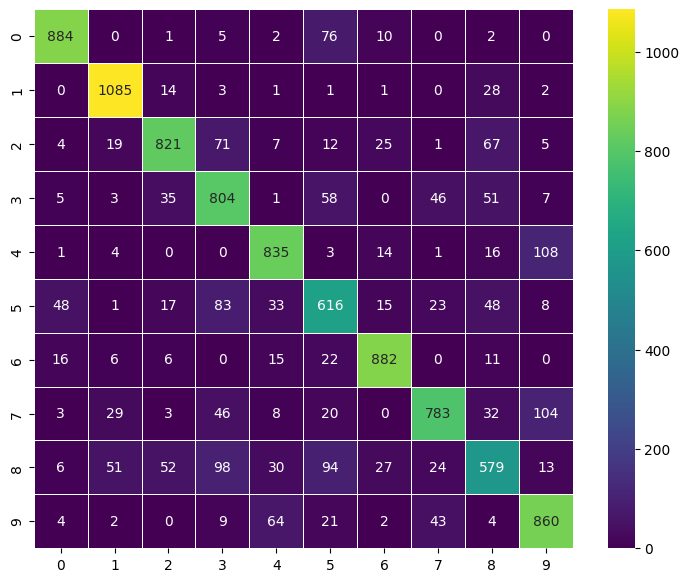

In [ ]:
confusion_matrix = tf.math.confusion_matrix(y_test, predictions)

f, ax = plt.subplots(figsize=(9, 7))
sn.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.7,
    fmt="d",
    square=True,
    ax=ax,
    cmap="viridis",
)
plt.show()